In [1]:
# 设置工作路径

setwd("/home/luojiawei/mimic3_Miss_project/")

In [31]:
# 加载库

library(stringr)
library(magrittr)
library(lubridate)
library(rlist)
library(data.table)
library(naniar)
library(mice)
library(pROC)
library(imputeTS)
library(DMwR2)
library(pheatmap)
library(emmeans)
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(tableone)
library(viridis)
library(purrr)

source("./util_funcs.R")

In [12]:
base_info<-fread("./base_info.csv",header=T,fill=T)

In [13]:
base_info[1:4,]

SUBJECT_ID,ROW_ID.x,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID.y,HADM_ID,⋯,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,AGE,TOTAL_LOS,Aids,Hm,Mc,cluster
<int>,<int>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<int>,<int>,<int>,⋯,<dttm>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
3,2,M,2025-04-11,2102-06-14,NA,2102-06-14,1,2,145834,⋯,2101-10-20 19:24:00,HYPOTENSION,0,1,78,258,0,0,0,1
4,3,F,2143-05-12,NA,NA,NA,0,3,185777,⋯,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,49,186,1,0,0,4
6,5,F,2109-06-21,NA,NA,NA,0,5,107064,⋯,NA,CHRONIC RENAL FAILURE/SDA,0,1,67,392,0,0,0,3
9,8,M,2108-01-26,2149-11-14,2149-11-14,2149-11-14,1,8,150750,⋯,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1,43,117,0,0,0,2


In [14]:
cluster<-fread("/home/luojiawei/mimic3_Miss_project/labels_cnn_autoencoder.csv",header=T)

In [15]:
base_info$cluster<-cluster$cluster+1

### 28 天院内死亡的性能评价

In [377]:
test_results<-fread("./result_test-1-a.csv",header=T,fill=T)

In [378]:
test_results[1:2,]

HADM_ID,death_within_28d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d_y,cluster
<int>,<dbl>,<dbl>,<int>,<int>,<int>
145834,0,0.801308155,0,0,4
107064,0,0.001804669,0,0,4


In [379]:
test_results$correct_pred<-as.integer(ifelse(test_results$PREDICTION >= 0.5,1,0) == test_results$death_within_28d_y)

In [380]:
base_info[1:2,]

SUBJECT_ID,ROW_ID.x,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID.y,HADM_ID,⋯,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,AGE,TOTAL_LOS,Aids,Hm,Mc,cluster
<int>,<int>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<int>,<int>,<int>,⋯,<dttm>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
3,2,M,2025-04-11,2102-06-14,NA,2102-06-14,1,2,145834,⋯,2101-10-20 19:24:00,HYPOTENSION,0,1,78,258,0,0,0,4
4,3,F,2143-05-12,NA,NA,NA,0,3,185777,⋯,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,49,186,1,0,0,1


In [381]:
test_results<-merge(test_results, base_info[,c("HADM_ID","AGE","GENDER","TOTAL_LOS","ADMISSION_TYPE")], by="HADM_ID", all.x=T)

In [382]:
test_results$TOTAL_LOS_cls<-cut(test_results$TOTAL_LOS, breaks = c(seq(48,24*7*4,24*7),Inf))

In [383]:
test_results[1:3,]

HADM_ID,death_within_28d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d_y,cluster,correct_pred,AGE,GENDER,TOTAL_LOS,ADMISSION_TYPE,TOTAL_LOS_cls
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<fct>
100010,0,0.02939785,0,0,5,1,56,F,105,ELECTIVE,"(48,216]"
100028,0,0.45526415,0,0,1,1,74,F,165,EMERGENCY,"(48,216]"
100030,0,0.01117696,0,0,1,1,35,M,381,EMERGENCY,"(216,384]"


In [384]:
fit<-glm(factor(correct_pred)~AGE+factor(GENDER)+factor(death_within_28d_y)+TOTAL_LOS_cls+ factor(ADMISSION_TYPE),
            data=test_results,
            family=binomial())

In [385]:
fit_best<-step(fit, direction='both')

Start:  AIC=7806.74
factor(correct_pred) ~ AGE + factor(GENDER) + factor(death_within_28d_y) + 
    TOTAL_LOS_cls + factor(ADMISSION_TYPE)

                             Df Deviance    AIC
<none>                            7788.7 7806.7
- factor(GENDER)              1   7806.9 7822.9
- factor(death_within_28d_y)  1   7815.2 7831.2
- AGE                         1   7898.9 7914.9
- factor(ADMISSION_TYPE)      2   7977.8 7991.8
- TOTAL_LOS_cls               3   8421.5 8433.5


In [386]:
summary(fit_best)


Call:
glm(formula = factor(correct_pred) ~ AGE + factor(GENDER) + factor(death_within_28d_y) + 
    TOTAL_LOS_cls + factor(ADMISSION_TYPE), family = binomial(), 
    data = test_results)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5874   0.2872   0.5253   0.6260   1.6056  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      3.2365119  0.1182136  27.379  < 2e-16 ***
AGE                             -0.0048902  0.0004523 -10.812  < 2e-16 ***
factor(GENDER)M                  0.2439268  0.0571491   4.268 1.97e-05 ***
factor(death_within_28d_y)1      0.4955177  0.0998213   4.964 6.90e-07 ***
TOTAL_LOS_cls(216,384]          -1.0263236  0.0671727 -15.279  < 2e-16 ***
TOTAL_LOS_cls(384,552]          -1.4454537  0.0901462 -16.035  < 2e-16 ***
TOTAL_LOS_cls(552,Inf]          -1.8921727  0.0920544 -20.555  < 2e-16 ***
factor(ADMISSION_TYPE)EMERGENCY -1.2857108  0.1072229 -11.991  < 2e-16 ***
factor(A

In [387]:
em <- emmeans(fit_best, ~TOTAL_LOS_cls)

In [388]:
C<-contrast(em, adjust = "bonferroni", method = "pairwise")
C<-print(C)

 contrast              estimate     SE  df z.ratio p.value
 (48,216] - (216,384]     1.026 0.0672 Inf  15.279  <.0001
 (48,216] - (384,552]     1.445 0.0901 Inf  16.035  <.0001
 (48,216] - (552,Inf]     1.892 0.0921 Inf  20.555  <.0001
 (216,384] - (384,552]    0.419 0.0950 Inf   4.413  0.0001
 (216,384] - (552,Inf]    0.866 0.0966 Inf   8.964  <.0001
 (384,552] - (552,Inf]    0.447 0.1135 Inf   3.935  0.0005

Results are averaged over the levels of: GENDER, death_within_28d_y, ADMISSION_TYPE 
Results are given on the log odds ratio (not the response) scale. 
P value adjustment: bonferroni method for 6 tests 


In [389]:
# 按照 cluster 进行分组
clusters <- sort(unique(test_results$TOTAL_LOS_cls),decreasing = F)

In [390]:
table1 <- CreateTableOne(vars = c("AGE", "GENDER", "HOSPITAL_EXPIRE_FLAG_y","TOTAL_LOS_cls","ADMISSION_TYPE"), 
                         factorVars = c("GENDER", "HOSPITAL_EXPIRE_FLAG_y","TOTAL_LOS_cls","ADMISSION_TYPE"),
                          strata = c("correct_pred"), 
                          data = test_results)

table1<-print(table1)
as.data.frame(table1)

Warning message in ModuleReturnVarsExist(vars, data):
“The data frame does not have: HOSPITAL_EXPIRE_FLAG_y  Dropped”
Warning message in ModuleReturnVarsExist(factorVars, data):
“The data frame does not have: HOSPITAL_EXPIRE_FLAG_y  Dropped”


                    Stratified by correct_pred
                     0             1             p      test
  n                   1814          6635                    
  AGE (mean (SD))    86.99 (60.80) 72.08 (51.54) <0.001     
  GENDER = M (%)       924 (50.9)   3885 (58.6)  <0.001     
  TOTAL_LOS_cls (%)                              <0.001     
     (48,216]          685 (37.8)   4540 (68.4)             
     (216,384]         546 (30.1)   1330 (20.0)             
     (384,552]         271 (14.9)    439 ( 6.6)             
     (552,Inf]         312 (17.2)    326 ( 4.9)             
  ADMISSION_TYPE (%)                             <0.001     
     ELECTIVE          107 ( 5.9)   1340 (20.2)             
     EMERGENCY        1657 (91.3)   5091 (76.7)             
     URGENT             50 ( 2.8)    204 ( 3.1)             


,0,1,p,test
,<chr>,<chr>,<chr>,<chr>
n,1814,6635,,
AGE (mean (SD)),86.99 (60.80),72.08 (51.54),<0.001,
GENDER = M (%),924 (50.9),3885 (58.6),<0.001,
TOTAL_LOS_cls (%),,,<0.001,
"(48,216]",685 (37.8),4540 (68.4),,
"(216,384]",546 (30.1),1330 (20.0),,
"(384,552]",271 (14.9),439 ( 6.6),,
"(552,Inf]",312 (17.2),326 ( 4.9),,
ADMISSION_TYPE (%),,,<0.001,


In [391]:
table1 <- CreateTableOne(vars = c("correct_pred", "AGE", "GENDER", "HOSPITAL_EXPIRE_FLAG_y","ADMISSION_TYPE"), 
                         factorVars = c("correct_pred","GENDER", "HOSPITAL_EXPIRE_FLAG_y","ADMISSION_TYPE"),
                          strata = c("TOTAL_LOS_cls"), 
                          data = test_results)

table1<-print(table1)
as.data.frame(table1)

Warning message in ModuleReturnVarsExist(vars, data):
“The data frame does not have: HOSPITAL_EXPIRE_FLAG_y  Dropped”
Warning message in ModuleReturnVarsExist(factorVars, data):
“The data frame does not have: HOSPITAL_EXPIRE_FLAG_y  Dropped”


                      Stratified by TOTAL_LOS_cls
                       (48,216]      (216,384]     (384,552]     (552,Inf]    
  n                     5225          1876           710           638        
  correct_pred = 1 (%)  4540 (86.9)   1330 (70.9)    439 (61.8)    326 (51.1) 
  AGE (mean (SD))      76.50 (57.68) 76.17 (50.89) 73.76 (48.88) 64.39 (31.39)
  GENDER = M (%)        2965 (56.7)   1096 (58.4)    388 (54.6)    360 (56.4) 
  ADMISSION_TYPE (%)                                                          
     ELECTIVE           1023 (19.6)    278 (14.8)     87 (12.3)     59 ( 9.2) 
     EMERGENCY          4068 (77.9)   1539 (82.0)    596 (83.9)    545 (85.4) 
     URGENT              134 ( 2.6)     59 ( 3.1)     27 ( 3.8)     34 ( 5.3) 
                      Stratified by TOTAL_LOS_cls
                       p      test
  n                               
  correct_pred = 1 (%) <0.001     
  AGE (mean (SD))      <0.001     
  GENDER = M (%)        0.341     
  ADMISSION_TY

,"(48,216]","(216,384]","(384,552]","(552,Inf]",p,test
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
n,5225,1876,710,638,,
correct_pred = 1 (%),4540 (86.9),1330 (70.9),439 (61.8),326 (51.1),<0.001,
AGE (mean (SD)),76.50 (57.68),76.17 (50.89),73.76 (48.88),64.39 (31.39),<0.001,
GENDER = M (%),2965 (56.7),1096 (58.4),388 (54.6),360 (56.4),0.341,
ADMISSION_TYPE (%),,,,,<0.001,
ELECTIVE,1023 (19.6),278 (14.8),87 (12.3),59 ( 9.2),,
EMERGENCY,4068 (77.9),1539 (82.0),596 (83.9),545 (85.4),,
URGENT,134 ( 2.6),59 ( 3.1),27 ( 3.8),34 ( 5.3),,


In [392]:
# 准确率及其置信区间
acc_ci <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarize(acc = mean(correct_pred),
            lower_ci = acc - 1.96 * sqrt(acc * (1 - acc) / n()),
            upper_ci = acc + 1.96 * sqrt(acc * (1 - acc) / n()))
            
# 死亡率及其置信区间
death_ci <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarize(death_rate = mean(HOSPITAL_EXPIRE_FLAG),
            lower_ci = death_rate - 1.96 * sqrt(death_rate * (1 - death_rate) / n()),
            upper_ci = death_rate + 1.96 * sqrt(death_rate * (1 - death_rate) / n()))

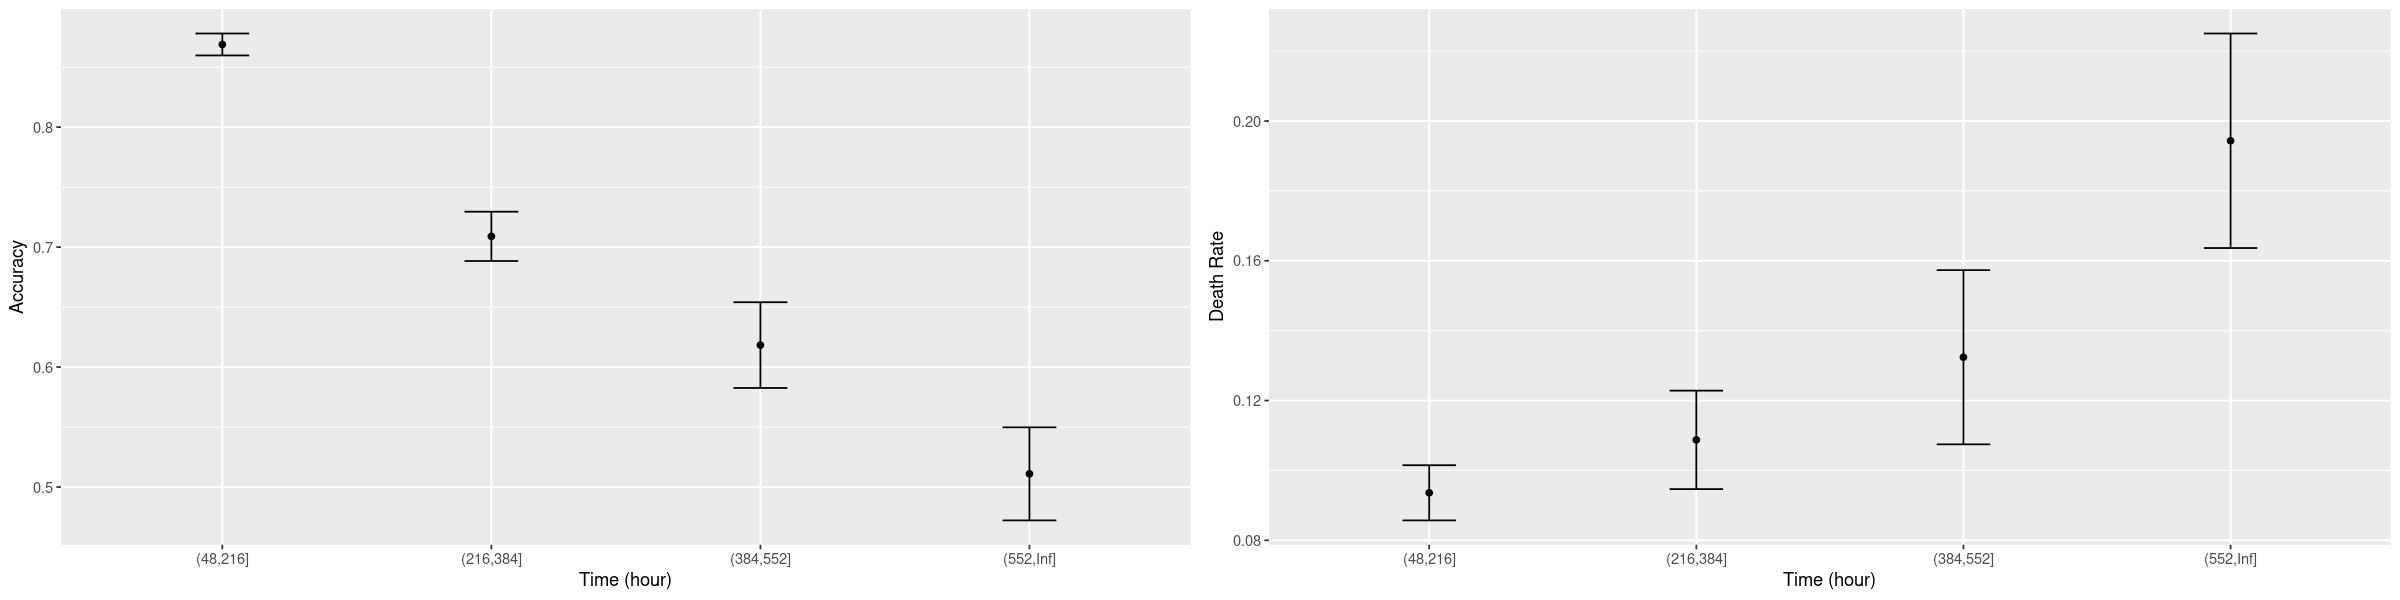

In [393]:
options(repr.plot.width=20, repr.plot.height=5)
grid.arrange(
  ggplot(acc_ci, aes(x = factor(TOTAL_LOS_cls), y = acc)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2) +
    labs(x = "Time (hour)", y = "Accuracy"),
  
  ggplot(death_ci, aes(x = factor(TOTAL_LOS_cls), y = death_rate)) +
    geom_point() +
    geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2) +
    labs(x = "Time (hour)", y = "Death Rate"),
  
  ncol = 2
)

In [397]:
library(ggplot2)
library(gridExtra)
library(viridis)

Loading required package: viridisLite



In [406]:
# 设置图形大小和字体
options(repr.plot.width = 14, repr.plot.height = 5, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

In [416]:
# 创建颜色变量
# colors <- viridis(4)
colors <- pastel.colors(4)

ERROR: Error in pastel.colors(4): could not find function "pastel.colors"


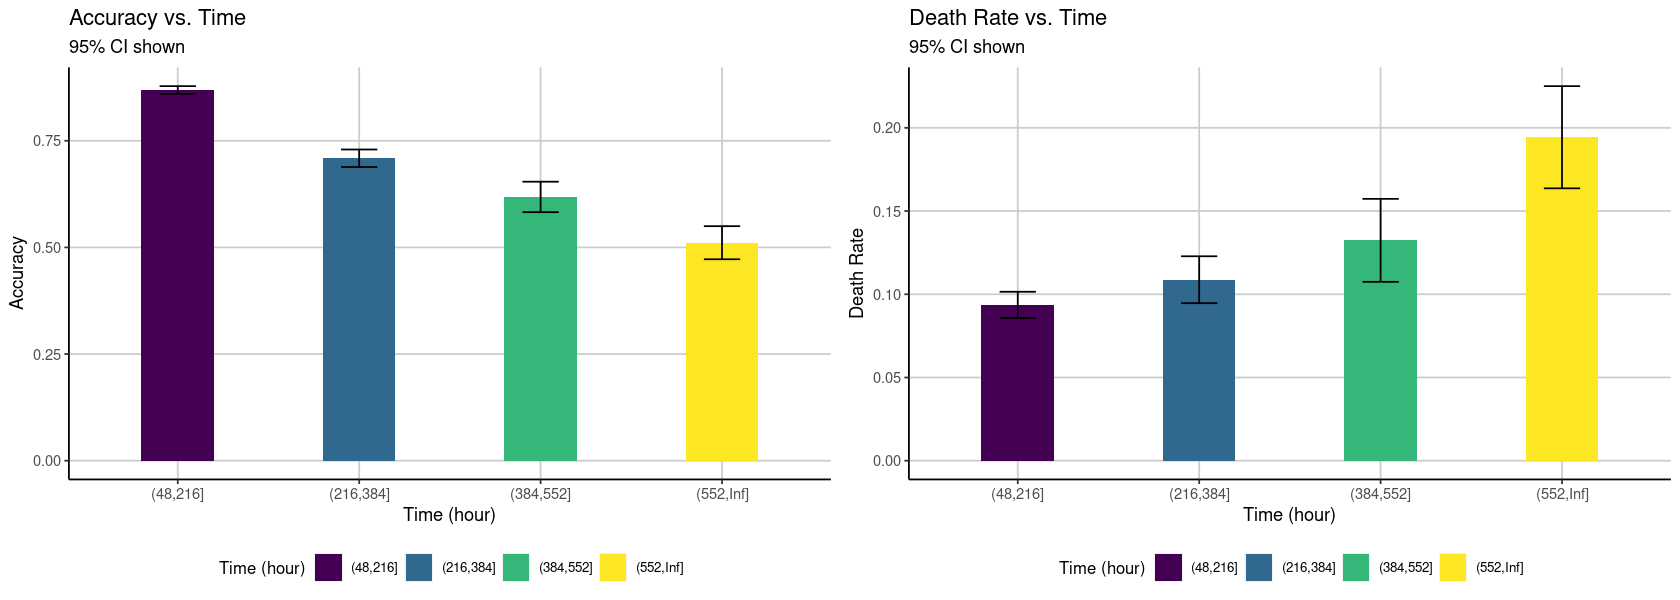

In [419]:
# 绘制图形
acc_plot <- ggplot(acc_ci, aes(x = factor(TOTAL_LOS_cls), y = acc, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge",width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Time (hour)", y = "Accuracy", title = "Accuracy vs. Time", subtitle = "95% CI shown", fill = "Time (hour)")

death_plot <- ggplot(death_ci, aes(x = factor(TOTAL_LOS_cls), y = death_rate, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge",width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Time (hour)", y = "Death Rate", title = "Death Rate vs. Time", subtitle = "95% CI shown", fill = "Time (hour)")

# 美化图形
acc_plot <- acc_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

death_plot <- death_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

# 组合图形
grid.arrange(acc_plot, death_plot, ncol = 2)

### 不限时间院内死亡的性能评价

In [1441]:
test_results<-fread("./result_train-1-b.csv",header=T,fill=T)

In [1442]:
test_results[1:2,]

HADM_ID,death_within_90d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d,death_within_90d_y
<int>,<dbl>,<dbl>,<int>,<int>,<int>
142735,1,0.5155954,1,1,1
145545,0,0.3469888,0,0,1


In [1443]:
test_results$correct_pred<-as.integer(ifelse(test_results$PREDICTION >= 0.5,1,0) == test_results$death_within_90d_y)

In [1444]:
base_info[1:2,]

SUBJECT_ID,ROW_ID.x,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID.y,HADM_ID,⋯,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,AGE,TOTAL_LOS,Aids,Hm,Mc,cluster
<int>,<int>,<chr>,<dttm>,<dttm>,<dttm>,<dttm>,<int>,<int>,<int>,⋯,<dttm>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
3,2,M,2025-04-11,2102-06-14,NA,2102-06-14,1,2,145834,⋯,2101-10-20 19:24:00,HYPOTENSION,0,1,78,258,0,0,0,4
4,3,F,2143-05-12,NA,NA,NA,0,3,185777,⋯,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,49,186,1,0,0,1


In [1445]:
test_results<-merge(test_results, base_info[,c("HADM_ID","AGE","GENDER","TOTAL_LOS","ADMISSION_TYPE")], by="HADM_ID", all.x=T)

In [1446]:
test_results$TOTAL_LOS_cls<-cut(test_results$TOTAL_LOS, breaks = c(seq(48,24*7*4,24*7),Inf),right=F)

In [1447]:
test_results[1:3,]

HADM_ID,death_within_90d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d,death_within_90d_y,correct_pred,AGE,GENDER,TOTAL_LOS,ADMISSION_TYPE,TOTAL_LOS_cls
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<fct>
100009,0,0.1853551,0,0,0,1,62,M,117,EMERGENCY,"[48,216)"
100012,0,0.1401661,0,0,0,1,69,M,242,EMERGENCY,"[216,384)"
100016,0,0.6092717,0,0,1,1,57,M,148,EMERGENCY,"[48,216)"


In [1448]:
fit<-glm(factor(correct_pred)~AGE+factor(GENDER)+factor(death_within_90d_y) + TOTAL_LOS_cls + factor(ADMISSION_TYPE) ,data=test_results,family=binomial())

#fit<-glm(factor(correct_pred)~TOTAL_LOS_cls,data=test_results,family=binomial())

In [1449]:
fit_best<-step(fit, direction='both')

Start:  AIC=17906.59
factor(correct_pred) ~ AGE + factor(GENDER) + factor(death_within_90d_y) + 
    TOTAL_LOS_cls + factor(ADMISSION_TYPE)

                             Df Deviance   AIC
<none>                             17889 17907
- factor(ADMISSION_TYPE)      2    17897 17911
- factor(GENDER)              1    17896 17912
- AGE                         1    17911 17927
- TOTAL_LOS_cls               3    17952 17964
- factor(death_within_90d_y)  1    18221 18237


In [1450]:
sumfit<-summary(fit_best)

In [1451]:
write.csv(sumfit$coefficients, file="./sumfit_coefficients.csv",row.names=T)

In [1452]:
em <- emmeans(fit_best, ~TOTAL_LOS_cls)

In [1453]:
C<-contrast(em, adjust = "bonferroni", method = "pairwise")
C<-print(C)
# as.data.frame(C)

 contrast              estimate     SE  df z.ratio p.value
 [48,216) - [216,384)    0.2279 0.0449 Inf   5.081  <.0001
 [48,216) - [384,552)    0.3091 0.0658 Inf   4.696  <.0001
 [48,216) - [552,Inf)    0.4128 0.0657 Inf   6.281  <.0001
 [216,384) - [384,552)   0.0812 0.0714 Inf   1.137  1.0000
 [216,384) - [552,Inf)   0.1848 0.0711 Inf   2.599  0.0560
 [384,552) - [552,Inf)   0.1037 0.0856 Inf   1.211  1.0000

Results are averaged over the levels of: GENDER, death_within_90d_y, ADMISSION_TYPE 
Results are given on the log odds ratio (not the response) scale. 
P value adjustment: bonferroni method for 6 tests 


In [1454]:
# 按照 cluster 进行分组
# clusters <- 1:5
clusters <- sort(unique(test_results$TOTAL_LOS_cls),decreasing = F)

In [1455]:
# 初始化结果矩阵
results <- matrix(NA, nrow = length(clusters), ncol = length(clusters))
colnames(results) <- clusters
rownames(results) <- clusters

In [1456]:
# 对每一对 cluster 进行 delong test
for (i in 1:length(clusters)) {
  for (j in 1:length(clusters)) {
    if (i == j) {
      results[i, j] <- NA
    } else {
      # 提取当前两个 cluster 的数据
      data_i <- test_results[test_results$TOTAL_LOS_cls == clusters[i], ]
      data_j <- test_results[test_results$TOTAL_LOS_cls == clusters[j], ]
      # 进行 delong test
      roc_i <- roc(data_i$death_within_90d_y, data_i$PREDICTION,quiet=T)
      roc_j <- roc(data_j$death_within_90d_y, data_j$PREDICTION,quiet=T)
      results[i, j] <- roc.test(roc_i, roc_j, method = "delong")$p.value
    }
  }
}

In [1457]:
# 输出结果
round(results,3)

,"[48,216)","[216,384)","[384,552)","[552,Inf)"
"[48,216)",NA,0.000,0.000,0.000
"[216,384)",0,NA,0.128,0.000
"[384,552)",0,0.128,NA,0.076
"[552,Inf)",0,0.000,0.076,NA


In [1458]:
table1 <- CreateTableOne(vars = c("AGE", "GENDER", "death_within_90d_y","TOTAL_LOS_cls","ADMISSION_TYPE","cluster"), 
                         factorVars = c("GENDER", "death_within_90d_y","TOTAL_LOS_cls","ADMISSION_TYPE","cluster"),
                          strata = c("correct_pred"), 
                          data = test_results)

table1<-print(table1)

Warning message in ModuleReturnVarsExist(vars, data):
“The data frame does not have: cluster  Dropped”
Warning message in ModuleReturnVarsExist(factorVars, data):
“The data frame does not have: cluster  Dropped”


                            Stratified by correct_pred
                             0             1             p      test
  n                           3993         12901                    
  AGE (mean (SD))            83.07 (57.75) 73.09 (52.57) <0.001     
  GENDER = M (%)              2158 (54.0)   7470 (57.9)  <0.001     
  death_within_90d_y = 1 (%)  2036 (51.0)   4071 (31.6)  <0.001     
  TOTAL_LOS_cls (%)                                      <0.001     
     [48,216)                 2185 (54.7)   8217 (63.7)             
     [216,384)                1004 (25.1)   2794 (21.7)             
     [384,552)                 391 ( 9.8)    982 ( 7.6)             
     [552,Inf)                 413 (10.3)    908 ( 7.0)             
  ADMISSION_TYPE (%)                                     <0.001     
     ELECTIVE                  561 (14.0)   2408 (18.7)             
     EMERGENCY                3300 (82.6)  10124 (78.5)             
     URGENT                    132 ( 3.3)    369

In [1459]:
as.data.frame(table1)

,0,1,p,test
,<chr>,<chr>,<chr>,<chr>
n,3993,12901,,
AGE (mean (SD)),83.07 (57.75),73.09 (52.57),<0.001,
GENDER = M (%),2158 (54.0),7470 (57.9),<0.001,
death_within_90d_y = 1 (%),2036 (51.0),4071 (31.6),<0.001,
TOTAL_LOS_cls (%),,,<0.001,
"[48,216)",2185 (54.7),8217 (63.7),,
"[216,384)",1004 (25.1),2794 (21.7),,
"[384,552)",391 ( 9.8),982 ( 7.6),,
"[552,Inf)",413 (10.3),908 ( 7.0),,


In [1460]:
table1 <- CreateTableOne(vars = c("correct_pred", "AGE", "GENDER", "death_within_90d_y","ADMISSION_TYPE"), 
                         factorVars = c("correct_pred","GENDER", "death_within_90d_y","ADMISSION_TYPE"),
                          strata = c("TOTAL_LOS_cls"), 
                          data = test_results)
non_norm<-c("AGE")
table1<-print(table1, nonnormal = non_norm)

                            Stratified by TOTAL_LOS_cls
                             [48,216)             [216,384)           
  n                          10402                 3798               
  correct_pred = 1 (%)        8217 (79.0)          2794 (73.6)        
  AGE (median [IQR])         67.00 [53.00, 79.00] 69.00 [57.00, 80.00]
  GENDER = M (%)              5955 (57.2)          2115 (55.7)        
  death_within_90d_y = 1 (%)  3238 (31.1)          1574 (41.4)        
  ADMISSION_TYPE (%)                                                  
     ELECTIVE                 2122 (20.4)           546 (14.4)        
     EMERGENCY                8001 (76.9)          3137 (82.6)        
     URGENT                    279 ( 2.7)           115 ( 3.0)        
                            Stratified by TOTAL_LOS_cls
                             [384,552)            [552,Inf)            p     
  n                           1373                 1321                      
  correct_pred = 1 (%)

In [1440]:
write.csv(as.data.frame(table1), file="./total_los_cls_table.csv")

In [1461]:
# 准确率及其置信区间
acc_ci <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarize(acc = mean(correct_pred),
            lower_ci = acc - 1.96 * sqrt(acc * (1 - acc) / n()),
            upper_ci = acc + 1.96 * sqrt(acc * (1 - acc) / n()))
            
# 死亡率及其置信区间
death_ci <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarize(death_rate = mean(death_within_90d_y),
            lower_ci = death_rate - 1.96 * sqrt(death_rate * (1 - death_rate) / n()),
            upper_ci = death_rate + 1.96 * sqrt(death_rate * (1 - death_rate) / n()))
            

roc_df <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarise(auroc = list(roc(death_within_90d_y, PREDICTION, quiet = T)),
            n = n()) %>%
  mutate(auroc = map(auroc, ~ list(auc = .x$auc))) %>%
  unnest(auroc) %>%
  mutate(ci = map(auroc, ~ ci.auc(.x)),
         lower_ci = map_dbl(ci, ~ .x[1]),
         upper_ci = map_dbl(ci, ~ .x[3])) %>%
  select(TOTAL_LOS_cls, auroc, lower_ci, upper_ci) %>%
  ungroup()

In [1462]:
roc_df$auroc<-unlist(lapply(roc_df$auroc, function(x)x[[1]]))

In [1463]:
# 定义函数计算auprc和标准差
get_auprc <- function(prediction, label) {
  curves <- evalmod(scores = prediction, labels = label)
  prc <- attr(curves$prcs[[1]], "auc")
  se <- get_prc_se(prediction, label)
  return(list(auprc = prc, se = se))
}

# 计算auprc和标准差
auprc_list <- test_results %>%
  group_by(TOTAL_LOS_cls) %>%
  summarize(auprc = get_auprc(PREDICTION, death_within_90d_y)[[1]], se=get_auprc(PREDICTION, death_within_90d_y)[[2]][2])

auprc_list <- auprc_list %>%
  mutate(lower_ci = auprc - 1.96 * se,
         upper_ci = auprc + 1.96 * se)

auprc_list <- auprc_list[, c("TOTAL_LOS_cls", "auprc","lower_ci","upper_ci")]

In [1464]:
em1<-summary(em)
fun<-function(x)exp(x)/(1+exp(x))
acc_corrected<-ggplot(em1, aes(x = TOTAL_LOS_cls, y = fun(emmean), fill = TOTAL_LOS_cls)) +
  geom_col(position = "dodge", width = 0.4) +
  geom_errorbar(aes(ymin = fun(asymp.LCL), ymax = fun(asymp.UCL)), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Length of stay category", y = "Adjusted accuracy", title = "Adjusted accuracy vs. Length of stay", subtitle = "95% CI shown", fill = "Length of stay category") + 
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))


In [1465]:
# 设置图形大小和字体
options(repr.plot.width = 14, repr.plot.height = 5, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

In [1466]:
# 创建颜色变量
colors <- viridis(4, option = "D")
substr(colors,8,9)<-"bb"
# colors <- pastel.colors(4)

In [1467]:
# 绘制图形
acc_plot <- ggplot(acc_ci, aes(x = factor(TOTAL_LOS_cls), y = acc, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge",width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Length of stay category", y = "Accuracy", title = "Accuracy vs. Length of stay", subtitle = "95% CI shown", fill = "Length of stay category")

death_plot <- ggplot(death_ci, aes(x = factor(TOTAL_LOS_cls), y = death_rate, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge",width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Length of stay category", y = "Death Rate", title = "Death Rate vs. Length of stay", subtitle = "95% CI shown", fill = "Length of stay category")

roc_plot <- ggplot(roc_df, aes(x = factor(TOTAL_LOS_cls), y = auroc, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge", width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Length of stay category", y = "AUROC", title = "AUROC vs. Length of stay", subtitle = "95% CI shown", fill = "Length of stay category")

auprc_plot <- ggplot(auprc_list, aes(x = factor(TOTAL_LOS_cls), y = auprc, fill = factor(TOTAL_LOS_cls))) +
  geom_col(position = "dodge",width = 0.4) +
  geom_errorbar(aes(ymin = lower_ci, ymax = upper_ci), width = 0.2, position = position_dodge(0.9)) +
  scale_fill_manual(values = colors) +
  labs(x = "Length of stay category", y = "AUPRC", title = "AUPRC vs. Length of stay", subtitle = "95% CI shown", fill = "Length of stay category")



# 美化图形
acc_plot <- acc_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

death_plot <- death_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

roc_plot <- roc_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

auprc_plot <- auprc_plot +
  theme(plot.background = element_blank(),
        panel.background = element_blank(),
        legend.position = "bottom",
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid.major = element_line(color = "grey80"),
        panel.grid.minor = element_blank(),
        axis.line = element_line(color = "black"))

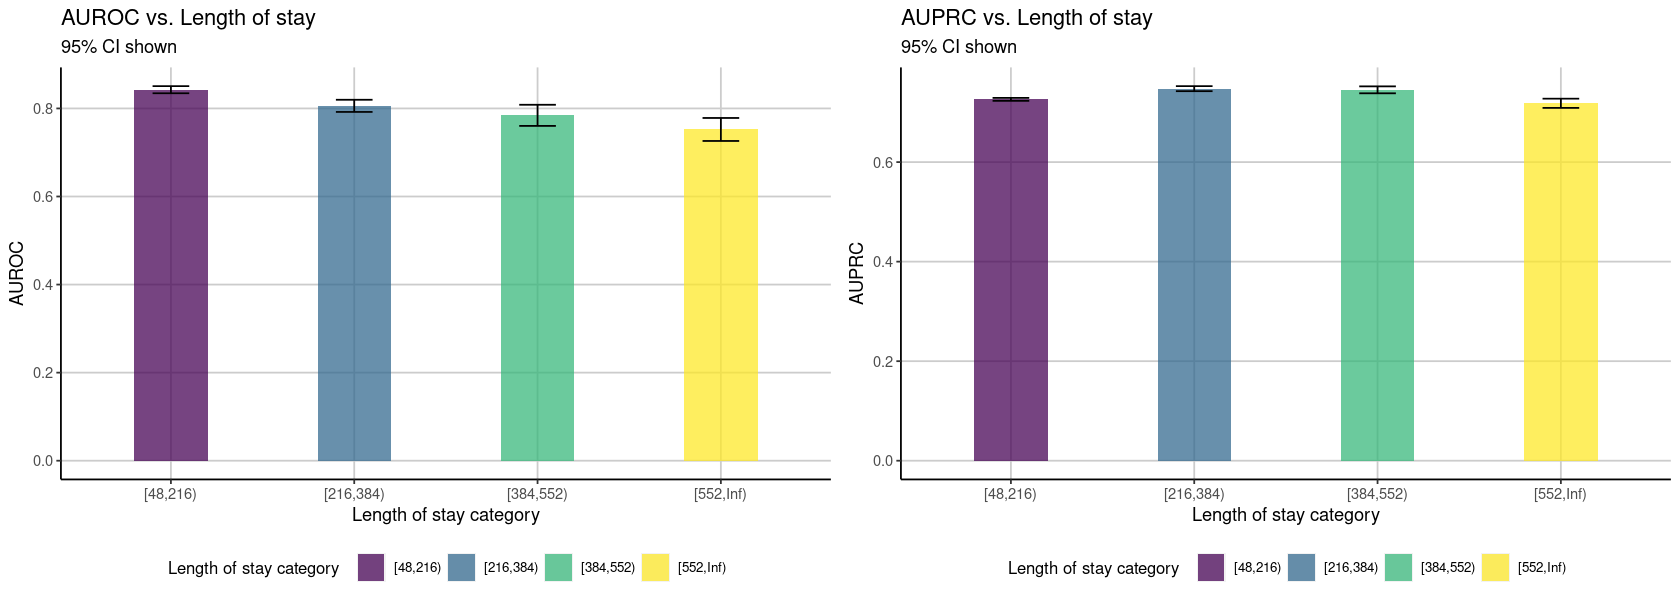

In [1468]:
grid.arrange(roc_plot, auprc_plot, ncol = 2)

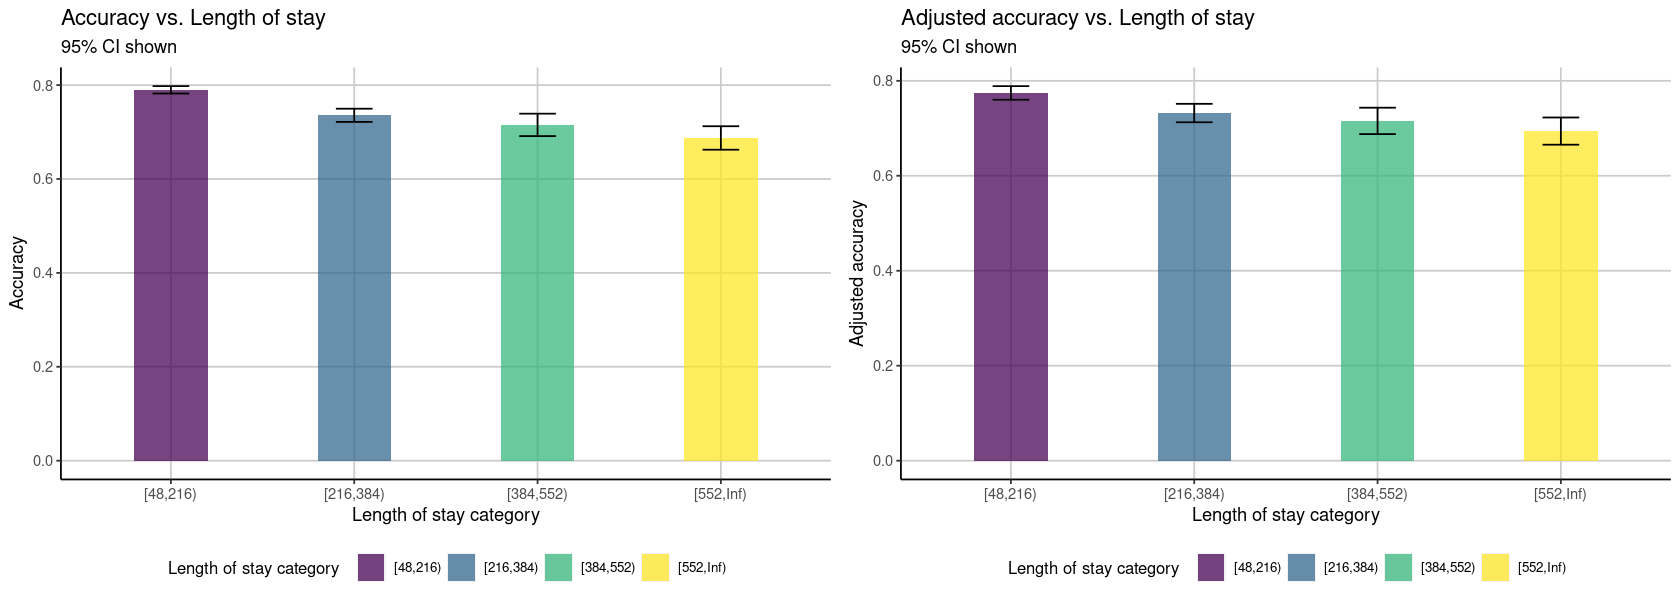

In [1469]:
grid.arrange(acc_plot, acc_corrected, ncol = 2)

In [1470]:
em1

,TOTAL_LOS_cls,emmean,SE,df,asymp.LCL,asymp.UCL
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"[48,216)",1.2357114,0.04191755,Inf,1.1535545,1.3178683
2,"[216,384)",1.0077950,0.05063523,Inf,0.9085518,1.1070382
3,"[384,552)",0.9266367,0.06984976,Inf,0.7897337,1.0635397
4,"[552,Inf)",0.8229512,0.06897641,Inf,0.6877599,0.9581424


In [1471]:

acc_ci <- acc_ci %>%
  mutate(acc = paste0(round(acc, 3), " (", round(lower_ci, 3), ", ", round(upper_ci, 3), ")"))

death_ci <- death_ci %>%
  mutate(death_rate = paste0(round(death_rate, 3), " (", round(lower_ci, 3), ", ", round(upper_ci, 3), ")"))

roc_df <- roc_df %>%
  mutate(auroc = paste0(round(auroc, 3), " (", round(lower_ci, 3), ", ", round(upper_ci, 3), ")"))

fun<-function(x)exp(x)/(1+exp(x))
em1 <- em1 %>%
  mutate(emmean = paste0(round(fun(emmean), 3), " (", round(fun(asymp.LCL), 3), ", ", round(fun(asymp.UCL), 3), ")"))

auprc_list <- auprc_list %>%
  mutate(auprc = paste0(round(auprc, 3), " (", round(lower_ci, 3), ", ", round(upper_ci, 3), ")"))


In [1472]:
merged_df <- bind_cols(roc_df[, c(1,2)],auprc_list[,-c(1,3,4)])
merged_df

TOTAL_LOS_cls,auroc,auprc
<fct>,<chr>,<chr>
"[48,216)","0.843 (0.834, 0.851)","0.726 (0.723, 0.729)"
"[216,384)","0.806 (0.792, 0.82)","0.748 (0.743, 0.753)"
"[384,552)","0.784 (0.76, 0.808)","0.745 (0.738, 0.752)"
"[552,Inf)","0.752 (0.726, 0.778)","0.718 (0.709, 0.727)"


In [1473]:
merged_df <- bind_cols(acc_ci[,c(1,2)], em1[,-c(1,3,4,5,6),drop=F])
merged_df

TOTAL_LOS_cls,acc,emmean
<fct>,<chr>,<chr>
"[48,216)","0.79 (0.782, 0.798)","0.775 (0.76, 0.789)"
"[216,384)","0.736 (0.722, 0.75)","0.733 (0.713, 0.752)"
"[384,552)","0.715 (0.691, 0.739)","0.716 (0.688, 0.743)"
"[552,Inf)","0.687 (0.662, 0.712)","0.695 (0.665, 0.723)"


In [1474]:
# 设置图形大小和字体
options(repr.plot.width = 12, repr.plot.height = 6, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

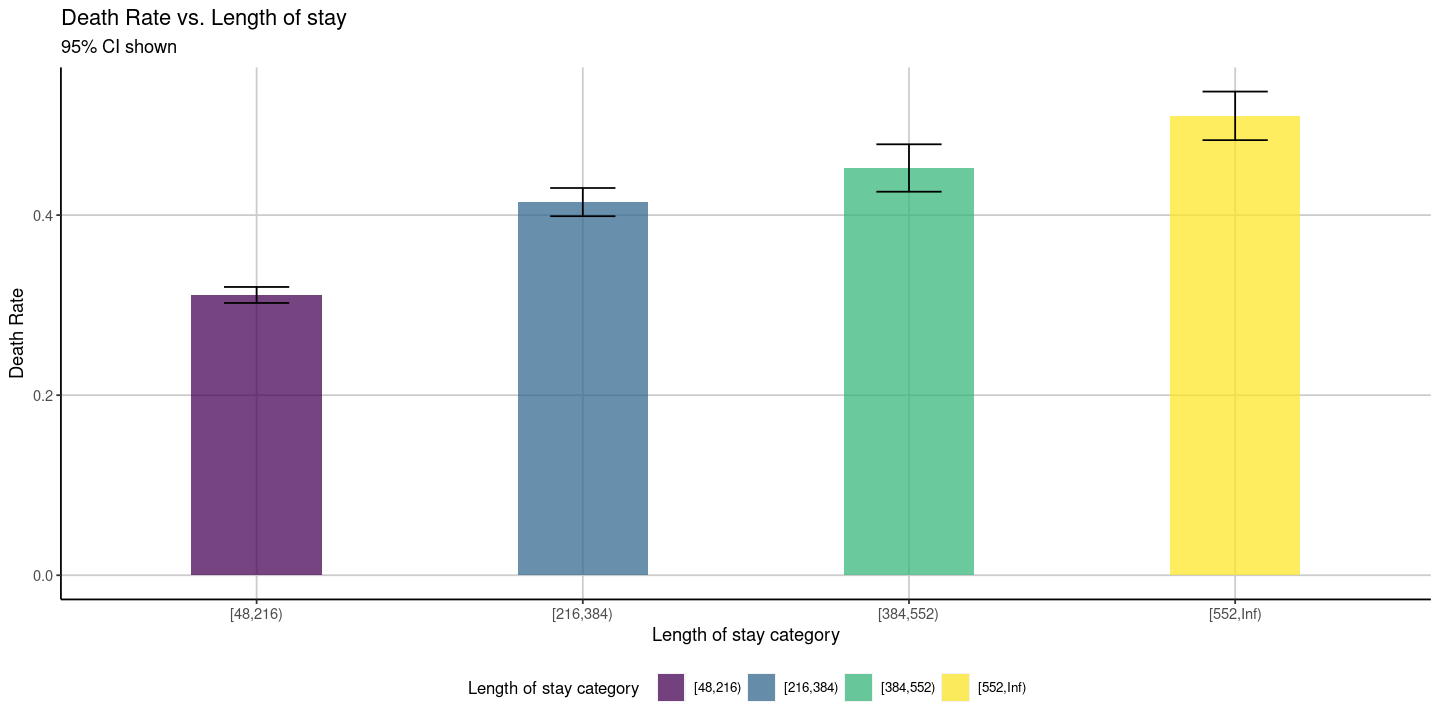

In [1475]:
death_plot

In [1476]:
# 绘制预测值的 calibration curve
# 分桶
test_results$bins <- cut(test_results$PREDICTION, breaks = seq(0, 1, by = 0.1))

# 计算平均预测概率和实际发生率
test_results_avg <- aggregate(cbind(death_within_90d_y, PREDICTION) ~ bins, test_results, mean)
names(test_results_avg) <- c("bins", "mean_true", "mean_pred")

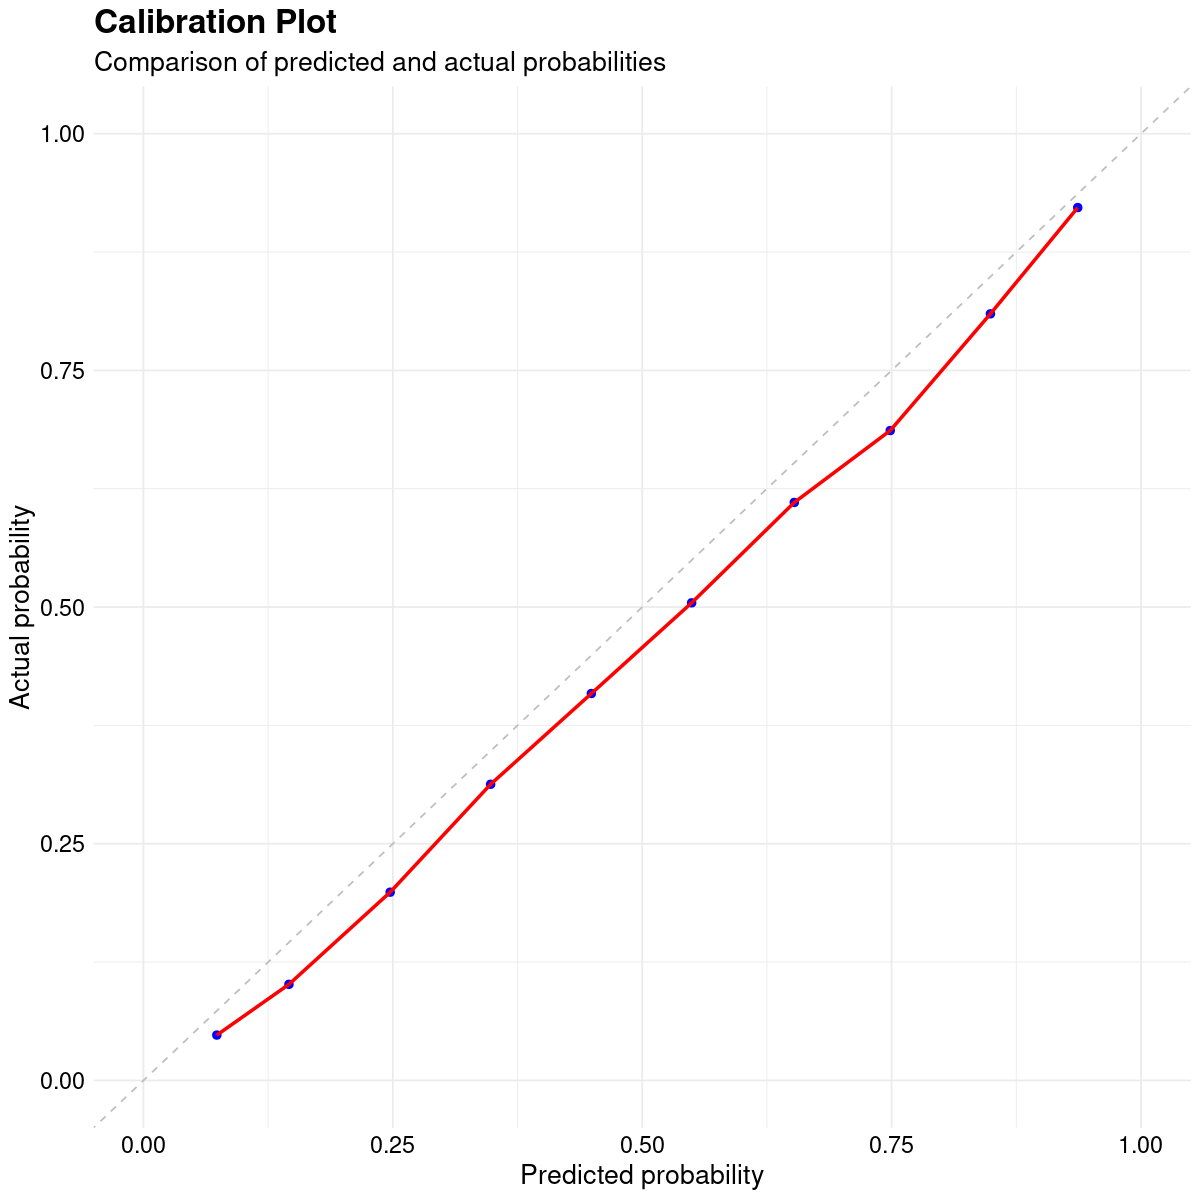

In [1477]:
# 设置图形大小和字体
options(repr.plot.width = 10, repr.plot.height = 10, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))


# 创建ggplot对象
ggplot(test_results_avg, aes(x = mean_pred, y = mean_true)) +
  # 绘制点图和线图
  geom_point(size = 2, color = "blue") +
  geom_line(color = "red", size = 1) +
  # 添加对角线
  geom_abline(slope = 1, intercept = 0, color = "gray", linetype = "dashed") +
  # 设置x轴和y轴的标签和标题
  labs(x = "Predicted probability", y = "Actual probability", 
       title = "Calibration Plot",
       subtitle = "Comparison of predicted and actual probabilities") +
  # 设置图形主题、颜色和字体
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
      plot.subtitle = element_text(size = 16),
      axis.title = element_text(size = 16),
      axis.text = element_text(size = 14, color = "black"), # 将颜色更改为黑色
      legend.title = element_blank(),
      legend.text = element_text(size = 14)) +
  # 设置坐标系的范围
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  # 添加图例
  scale_color_manual(values = c("blue", "red"), 
                     labels = c("Predicted probability", "Actual probability")) +
  guides(color = guide_legend(override.aes = list(size = 2)))



In [1478]:

# 我想画不同 TOTAL_LOS_cls 的组的  calibration curve
# TOTAL_LOS_cls 已经分好组了，不需要重新划分了
# 提示：从 test_results 里面根据 TOTAL_LOS_cls 的不同取值，使用对应的行来粉笔绘制 calibration curve
# 按照 TOTAL_LOS_cls 分别绘制 calibration curve
# 用本文件213行到243行的代码的方式来绘制，修改下面的代码
calibration_curves <- lapply(levels(test_results$TOTAL_LOS_cls), function(cls) {
  # 选择对应组的数据
  cls_data <- test_results[test_results$TOTAL_LOS_cls == cls, ]
  # 对cls_data中的PREDICTION进行分桶
  cls_data$bins <- cut(cls_data$PREDICTION, breaks = seq(0, 1, by = 0.1))
  # 将test_results改成cls_data
  cls_data_avg <- aggregate(cbind(death_within_90d_y, PREDICTION) ~ bins, cls_data, mean)
  names(cls_data_avg) <- c("bins", "mean_true", "mean_pred")


  # 把test_results_avg替换为cls_data_avg
  calibrate_curve <- ggplot(cls_data_avg, aes(x = mean_pred, y = mean_true)) +
  geom_point(size = 2, color = "#0072B2") +
  geom_line(color = "#D55E00", size = 1) +
  geom_abline(slope = 1, intercept = 0, color = "gray", linetype = "dashed") +
  labs(x = "Predicted probability", y = "Actual probability", 
       title = NULL,
       subtitle = paste0(cls, "  (hour)")) +
  theme_bw() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        plot.subtitle = element_text(size = 16),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14, color = "#333333"),
        legend.title = element_blank(),
        legend.text = element_text(size = 14)) +
  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +
  scale_color_manual(values = c("#0072B2", "#D55E00"), 
                     labels = c("Predicted probability", "Actual probability")) +
  guides(color = guide_legend(override.aes = list(size = 2)))


  calibrate_curve
})

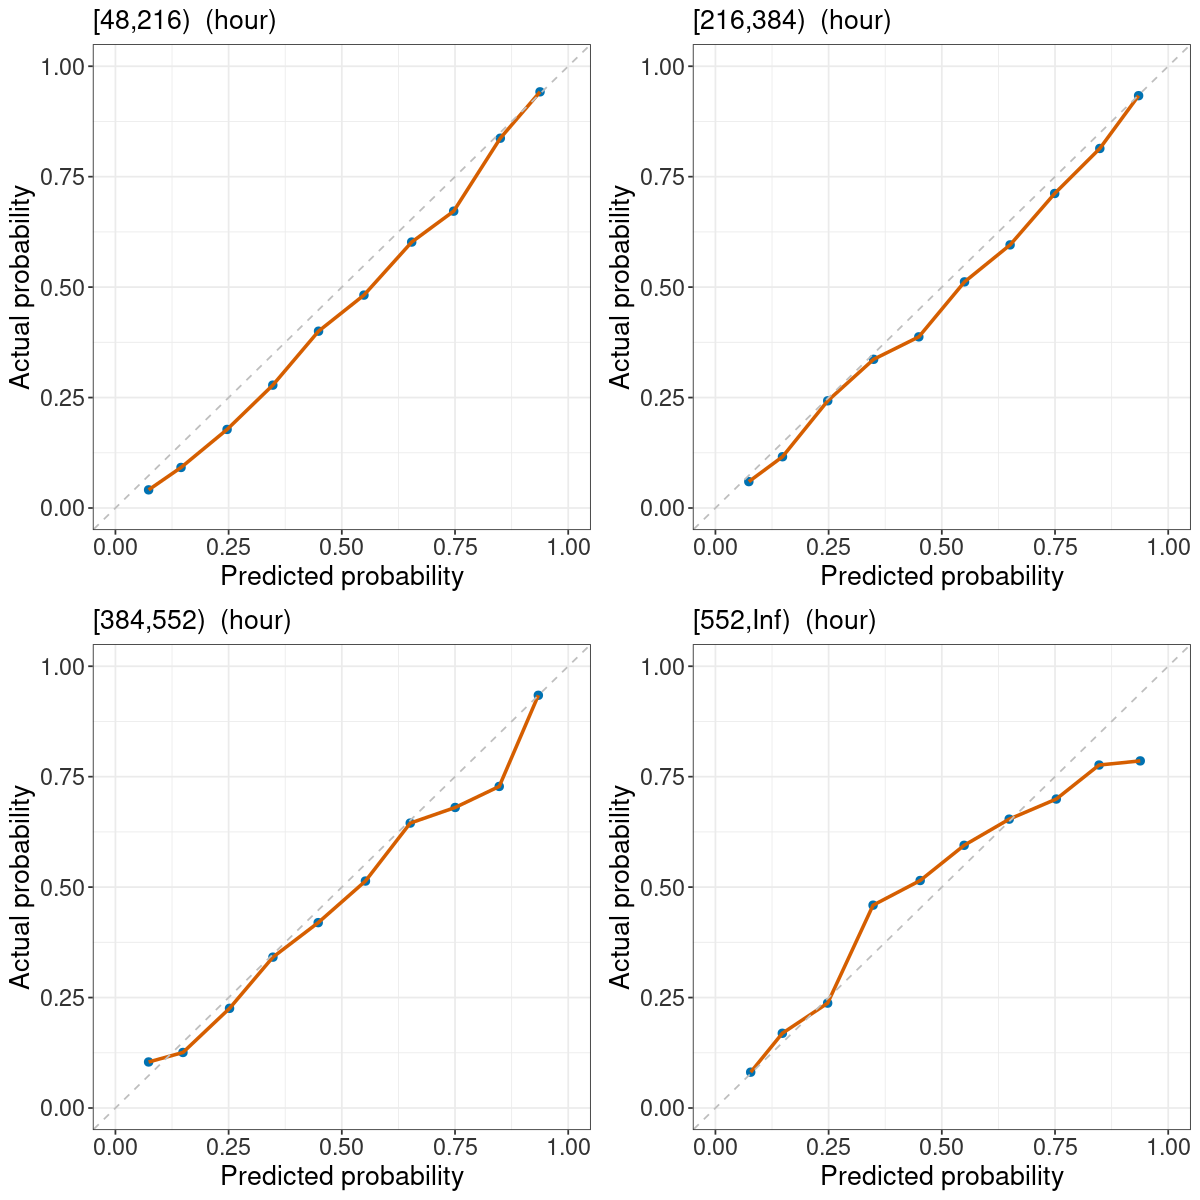

In [1479]:
# 设置图形大小和字体
options(repr.plot.width = 10, repr.plot.height = 10, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

# 将所有的calibration curve放在一起
combined_plot <- cowplot::plot_grid(plotlist = calibration_curves, ncol = 2, align = "h")
# 输出组合后的图形
print(combined_plot)

In [1096]:
library(pROC)
library(RColorBrewer)
library(precrec)


Attaching package: ‘precrec’


The following object is masked from ‘package:pROC’:

    auc




In [1101]:
test_results<-fread("./result_test-1-b.csv",header=T,fill=T)   
train_results<-fread("./result_train-1-b.csv",header=T,fill=T)   

In [1102]:
test_results<-merge(test_results, base_info[,c("HADM_ID","AGE","GENDER","TOTAL_LOS","ADMISSION_TYPE")], by="HADM_ID", all.x=T)
train_results<-merge(train_results, base_info[,c("HADM_ID","AGE","GENDER","TOTAL_LOS","ADMISSION_TYPE")], by="HADM_ID", all.x=T)

In [1103]:
all_ds<-list(train_results, test_results)

In [1104]:
get_prc_se<-function(x, y){
  n<-length(x)
  r1<-c();r2<-c()
  for(i in 1:20){
    ind<-sample(1:n, size=n, replace = T)
    curves1<-evalmod(scores=x[ind],labels=y[ind])
    r1<-c(r1,attr(curves1$rocs[[1]],"auc"))
    r2<-c(r2,attr(curves1$prcs[[1]],"auc"))
  }
  s1<-sd(r1)/sqrt(20)
  s2<-sd(r2)/sqrt(20)
  return(c(s1,s2))
}

In [1106]:
train_results[1:2,]

HADM_ID,death_within_90d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d,death_within_90d_y,AGE,GENDER,TOTAL_LOS,ADMISSION_TYPE
<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>
100009,0,0.1853551,0,0,0,62,M,117,EMERGENCY
100012,0,0.1401661,0,0,0,69,M,242,EMERGENCY


In [1108]:

CIs<-list()
for(i in 1:length(all_ds)){
  
  s<-get_prc_se(all_ds[[i]]$PREDICTION,all_ds[[i]]$death_within_90d_y)
  curves1<-evalmod(scores=all_ds[[i]]$PREDICTION,labels=all_ds[[i]]$death_within_90d_y)
  m1<-attr(curves1$rocs[[1]],"auc")
  m2<-attr(curves1$prcs[[1]],"auc")
  conf_int<-rbind(c(m1,m1-1.96*s[1],m1+1.96*s[1]),
                  c(m2,m2-1.96*s[2],m2+1.96*s[2]))
  conf_int<-round(conf_int, 3)
  CIs[[i]]<-conf_int
  print(i)
}


[1] 1
[1] 2


In [1111]:

# 把X0替换为death_within_90d_y,把X2替换为PREDICTION
Rocs<-list()
Rets<-list()
for(i in 1:length(all_ds)){
  
  ds1<-all_ds[[i]]
  
  roc1 <- roc(ds1$death_within_90d_y, ds1$PREDICTION)
  Rocs[[i]]<-roc1
  # auc(roc1)
  
  ths<-pROC::coords(roc1, x="all", input="threshold", ret=c("threshold"))

  rets<-pROC::ci.coords(roc1, x=ths$threshold,  input="threshold", 
                        ret=c("sensitivity","specificity" , "recall", "precision"))
  
  fun<-function(rets){
    index<-which(apply(rets$precision, 1, function(x){any(is.na(x))}))
    index<-index[index>=2]
    rets$precision[index,]<-rets$precision[index-1,]
    return(rets)
  }
  
  rets<-fun(rets)
  
  Rets[[i]]<-rets
  print(i)
  
}

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] 2


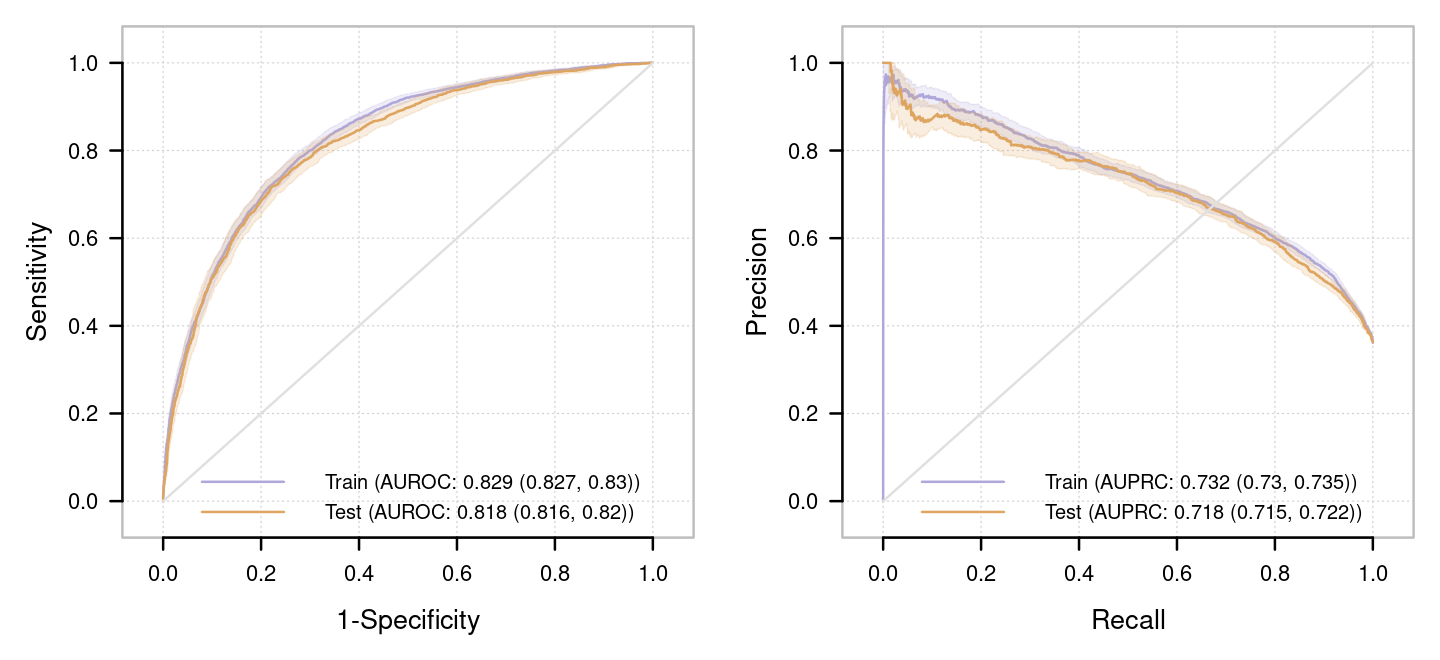

In [1131]:
# 设置图形大小和字体
options(repr.plot.width = 12, repr.plot.height = 5.5, 
        plot.title = element_text(size = 14, face = "bold"), 
        plot.subtitle = element_text(size = 12),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

cols<-c("#afa8da","#dfa562")
cols1<-cols;cols1<-paste0(cols1,"33")

par(mar=c(5,5,1,1)+0.1, mfrow=c(1,2))

plot.new()
plot.window(xlim=c(-0.04,1.04),ylim=c(-0.04,1.04))
grid()
for(i in 1:length(all_ds)){
  # i<-1
  rets<-Rets[[i]]
  
  lines(x=1-rets$specificity[,2], y=rets$sensitivity[,2],type='l',
        col=cols[i],lwd=2)
  polygon(x=c(1-rets$specificity[,1], 1-rev(rets$specificity[,3])), 
          y=c(rets$sensitivity[,1],rev(rets$sensitivity[,3])),
          border = cols1[i],
          col=cols1[i])
  
}
lines(x=c(0,1),y=c(0,1),col="#E0E0E0",lwd=2)
op<-par(cex=1.35)
title(xlab="1-Specificity", ylab='Sensitivity')
par(op)
op<-par(cex=1.1)
box(col="grey",lwd=2)
axis(1, at=seq(0, 1, 0.2), las=1,lwd=2)
axis(2, at=seq(0, 1, 0.2), las=1,lwd=2)
par(op)

lab<-c("Train",
       "Test")

lab1<-paste0(unlist(lapply(CIs[1:3], function(x) x[1,1])), " (", 
             unlist(lapply(CIs[1:3], function(x) x[1,2])), ", ",
             unlist(lapply(CIs[1:3], function(x) x[1,3])), ")")

lab2<-paste0(lab, " (AUROC: ", lab1, ")")

legend(x = 1.85, y = 0.1, legend=lab2, bty="n", lwd=2, col=cols, y.intersp = 1.6, xjust = 1)


plot.new()
plot.window(xlim=c(-0.04,1.04),ylim=c(-0.04,1.04))
grid()
i1<-1
for(i in 1:length(all_ds)){
  rets<-Rets[[i]]
  
  lines(x=rets$recall[,2], y=rets$precision[,2],type='l',
        col=cols[i1],lwd=2)
  polygon(x=c(rets$recall[,1], rev(rets$recall[,3])), 
          y=c(rets$precision[,1],rev(rets$precision[,3])),
          border = cols1[i1],
          col=cols1[i1])
  i1<-i1+1
  
}
lines(x=c(0,1),y=c(0,1),col="#E0E0E0",lwd=2)
op<-par(cex=1.35)
title(xlab="Recall", ylab='Precision')
par(op)
op<-par(cex=1.1)
box(col="grey",lwd=2)
axis(1, at=seq(0, 1, 0.2), las=1,lwd=2)
axis(2, at=seq(0, 1, 0.2), las=1,lwd=2)
par(op)


lab1<-paste0(unlist(lapply(CIs[1:3], function(x) x[2,1])), " (", 
             unlist(lapply(CIs[1:3], function(x) x[2,2])), ", ",
             unlist(lapply(CIs[1:3], function(x) x[2,3])), ")")

lab2<-paste0(lab, " (AUPRC: ", lab1, ")")

legend(x = 1.85, y = 0.1, legend=lab2, bty="n",  lwd=2, col=cols, y.intersp = 1.6, xjust = 1)

In [1082]:
conf_mat <- table(test_results$death_within_90d_y, test_results$PREDICTION > 0.5)
conf_mat

   
    FALSE TRUE
  0  4392  989
  1  1043 2023